In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_from_order_func
from optimizers.utils._utils import get_csv_data
from optimizers.utils.cross_validators import vbt_cv_sliding_constructor

In [2]:
pair = "bchsv1inch"
opens = get_csv_data(f"data/{pair}_hourly_opens.csv")
closes = get_csv_data(f"data/{pair}_hourly_closes.csv")
print(f"Full data length: {closes.shape[0]}")

train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=3)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=3)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 13267
Test data length: 3981
Train fold length 3095


In [12]:
# BNB -> TRX 550 2.1 -2.5 1.9 1e-5 1.5 CUMMLOG 0.0006 <- works dur 360/38 trades per epoch
# EOS FIL works on a CUMMLOG model but has volatility in per trade returns
# FIL THETA & LINK CHZ, BTC ZEC. BTCZEC might work, but had generalization issues
# DBG DASH does not generalize on either log or cummlog model
# GRT INCH is a bust for both models
# ADA ZEC is untestable due to massive regime shift mid test set for LOG model
# Something is bizarre and wrong with the ADA ZEC data; needs review?
# BSV 1INCH 70  2.1 -2.4 1.3 5.000000e-07 0.00030 CUMMLOG <- does not work past 10bps slippage
# 

PERIOD = 50
UPPER = 2.1
LOWER = -2.1
EXIT = 0.5
DELTA = 3e-6
VT = 1.4e-2
BURNIN = 300
MODEL = "log"
SLIPPAGE = 0.0020
FREQ = "h"

In [13]:
pf = simulate_from_order_func(
    closes, opens,
    period=PERIOD,
    upper=UPPER,
    lower=LOWER,
    exit=EXIT,
    delta=DELTA,
    vt=VT,
    burnin=BURNIN,
    freq=FREQ,
    hedge="beta",
    mode=MODEL,
    slippage=SLIPPAGE,
    order_size=0.10,
)

0.010343670383911126


<AxesSubplot:xlabel='time'>

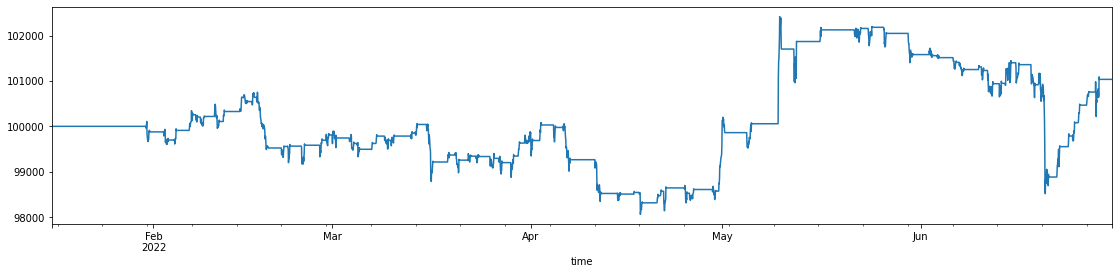

In [14]:
print(pf.total_return())
pf.value().plot(figsize=(19,4))

In [15]:
res = pf.trades.records_readable.groupby("Entry Timestamp").sum()

print(f"Total trades: {res.shape[0]}")
print(f"Executed trades: {pf.trades.records_readable.shape[0]}")
print(f"Profit Ratio: {res.PnL[res.PnL > 0].median() / np.abs(res.PnL[res.PnL < 0].median()):.3f}")
print(f"Net long-short win rate: {res.PnL[res.PnL > 0].shape[0] / res.shape[0] * 100:.2f}%")
print(f"Median trade profit: {res.PnL.median():.2f}")
print(f"Mean trade profit: {res.PnL.mean():.2f}")
print(f"STD of trade profit: {res.PnL.std():.2f}")
print(f"Sharpe ratio: {pf.sharpe_ratio():.4f}")

Total trades: 80
Executed trades: 160
Profit Ratio: 1.275
Net long-short win rate: 56.25%
Median trade profit: 22.31
Mean trade profit: 12.93
STD of trade profit: 426.65
Sharpe ratio: 0.4152


<AxesSubplot:xlabel='Entry Timestamp'>

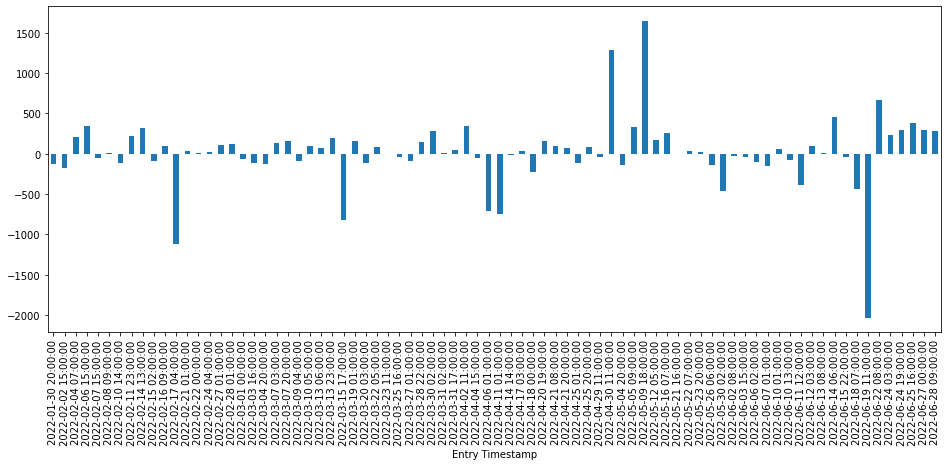

In [16]:
res.PnL.plot(kind="bar", figsize=(16,6))